In [21]:
import pandas as pd
import numpy as np
from itertools import cycle

## for visualisation ##
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize


## for modelling ##
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


## oversampling ##
from imblearn.over_sampling import SMOTE


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. EDA

In [22]:
hcdata = pd.read_csv('hcvdat0.csv')
hcdata.head(10)

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
5,6,0=Blood Donor,32,m,41.6,43.3,18.5,19.7,12.3,9.92,6.05,111.0,91.0,74.0
6,7,0=Blood Donor,32,m,46.3,41.3,17.5,17.8,8.5,7.01,4.79,70.0,16.9,74.5
7,8,0=Blood Donor,32,m,42.2,41.9,35.8,31.1,16.1,5.82,4.60,109.0,21.5,67.1
8,9,0=Blood Donor,32,m,50.9,65.5,23.2,21.2,6.9,8.69,4.10,83.0,13.7,71.3
9,10,0=Blood Donor,32,m,42.4,86.3,20.3,20.0,35.2,5.46,4.45,81.0,15.9,69.9


In [23]:
hcdata["Category"].value_counts()

0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [24]:
hcdata.drop(hcdata[hcdata['Category'] == '0s=suspect Blood Donor'].index, inplace=True)

In [25]:
hcdata["Category"].value_counts()

0=Blood Donor    533
3=Cirrhosis       30
1=Hepatitis       24
2=Fibrosis        21
Name: Category, dtype: int64

In [26]:
hcdata.describe()

,Unnamed: 0,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,608.000000,608.000000,607.000000,590.000000,607.000000,608.000000,608.000000,608.000000,598.000000,608.000000,608.000000,607.000000
mean,305.363487,47.291118,41.818781,67.821017,27.601318,34.369408,11.474013,8.204885,5.378829,81.513158,38.243914,72.253213
std,176.981084,9.992705,5.406717,25.274423,21.227539,32.622442,19.770558,2.168400,1.119394,49.720652,51.953220,4.932252
min,1.000000,19.000000,20.000000,11.300000,0.900000,12.000000,1.800000,1.420000,1.430000,8.000000,4.500000,51.000000
25%,152.750000,39.000000,39.000000,52.500000,16.400000,21.600000,5.300000,6.950000,4.620000,68.000000,15.700000,69.450000
50%,304.500000,47.000000,42.000000,66.000000,23.000000,25.850000,7.300000,8.270000,5.300000,77.000000,23.250000,72.200000
75%,456.250000,54.000000,45.250000,79.525000,32.750000,32.800000,11.300000,9.585000,6.075000,88.000000,39.200000,75.400000
max,615.000000,77.000000,82.200000,416.600000,258.000000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


In [27]:
hcdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  608 non-null    int64  
 1   Category    608 non-null    object 
 2   Age         608 non-null    int64  
 3   Sex         608 non-null    object 
 4   ALB         607 non-null    float64
 5   ALP         590 non-null    float64
 6   ALT         607 non-null    float64
 7   AST         608 non-null    float64
 8   BIL         608 non-null    float64
 9   CHE         608 non-null    float64
 10  CHOL        598 non-null    float64
 11  CREA        608 non-null    float64
 12  GGT         608 non-null    float64
 13  PROT        607 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 71.2+ KB


In [28]:
## chagne the column "Category" from object to category type for encoding
hcdata["Category"] = hcdata["Category"].astype('category')
hcdata["Category_coded"] = hcdata["Category"].cat.codes
hcdata["Sex"] = hcdata["Sex"].astype('category')
hcdata["Sex_coded"] = hcdata["Sex"].cat.codes
hcdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608 entries, 0 to 614
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Unnamed: 0      608 non-null    int64   
 1   Category        608 non-null    category
 2   Age             608 non-null    int64   
 3   Sex             608 non-null    category
 4   ALB             607 non-null    float64 
 5   ALP             590 non-null    float64 
 6   ALT             607 non-null    float64 
 7   AST             608 non-null    float64 
 8   BIL             608 non-null    float64 
 9   CHE             608 non-null    float64 
 10  CHOL            598 non-null    float64 
 11  CREA            608 non-null    float64 
 12  GGT             608 non-null    float64 
 13  PROT            607 non-null    float64 
 14  Category_coded  608 non-null    int8    
 15  Sex_coded       608 non-null    int8    
dtypes: category(2), float64(10), int64(2), int8(2)
memory usage: 6

In [29]:
hcdata["Category"].value_counts()

0=Blood Donor    533
3=Cirrhosis       30
1=Hepatitis       24
2=Fibrosis        21
Name: Category, dtype: int64

In [30]:
hcdata_encoded = hcdata.drop(['Sex','Category','Unnamed: 0'],axis=1)
hcdata_encoded.head()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Category_coded,Sex_coded
0,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0,1
1,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0,1
2,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0,1
3,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0,1
4,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0,1


In [31]:
hcdata_encoded.corr()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Category_coded,Sex_coded
Age,1.000000,-0.170138,0.165691,-0.042102,0.073111,0.035758,-0.080787,0.146670,-0.012079,0.141081,-0.122002,0.124079,-0.030400
ALB,-0.170138,1.000000,-0.099209,0.092611,-0.180774,-0.248960,0.381006,0.166669,-0.021206,-0.087750,0.480602,-0.316717,0.173310
ALP,0.165691,-0.099209,1.000000,0.071101,0.024504,0.064349,0.048188,0.135030,0.162796,0.421882,-0.006812,0.057375,-0.016095
ALT,-0.042102,0.092611,0.071101,1.000000,0.215161,-0.032033,0.173361,0.062697,-0.034862,0.169919,0.204289,0.094906,0.211407
AST,0.073111,-0.180774,0.024504,0.215161,1.000000,0.322628,-0.234705,-0.220186,-0.013165,0.496529,0.071277,0.645396,0.135468
BIL,0.035758,-0.248960,0.064349,-0.032033,0.322628,1.000000,-0.342546,-0.185584,0.031017,0.238781,-0.065814,0.499293,0.114114
CHE,-0.080787,0.381006,0.048188,0.173361,-0.234705,-0.342546,1.000000,0.425648,-0.012087,-0.091646,0.285723,-0.370050,0.172351
CHOL,0.146670,0.166669,0.135030,0.062697,-0.220186,-0.185584,0.425648,1.000000,-0.055956,0.013399,0.161668,-0.313321,-0.025290
CREA,-0.012079,-0.021206,0.162796,-0.034862,-0.013165,0.031017,-0.012087,-0.055956,1.000000,0.123133,-0.061982,0.203624,0.161610
GGT,0.141081,-0.087750,0.421882,0.169919,0.496529,0.238781,-0.091646,0.013399,0.123133,1.000000,0.073540,0.477942,0.138436


In [32]:
## grouping AgeGroup ##
hcdata_encoded.loc[(hcdata_encoded.Age.between(0, 19)), 'AgeGroup'] = 0
hcdata_encoded.loc[(hcdata_encoded.Age.between(20, 39)), 'AgeGroup'] = 1
hcdata_encoded.loc[(hcdata_encoded.Age.between(40, 59)), 'AgeGroup'] = 2
hcdata_encoded.loc[(hcdata_encoded.Age.between(60, 79)), 'AgeGroup'] = 3

In [33]:
## find missing values ##
hcdata_encoded.isnull().sum()

Age                0
ALB                1
ALP               18
ALT                1
AST                0
BIL                0
CHE                0
CHOL              10
CREA               0
GGT                0
PROT               1
Category_coded     0
Sex_coded          0
AgeGroup           0
dtype: int64

In [34]:
## missing data handling, NaN values replaced with median value grouped by 'Sex_coded','Category_coded', 'AgeGroup' ###
## one observation on the AgeGroup < 19 appears only 1, so not grouped by AgeGroup
hcdata_encoded['ALB'] = hcdata_encoded['ALB'].fillna(hcdata_encoded.groupby(['Sex_coded','Category_coded', 'AgeGroup'])['ALB'].transform('median'))
hcdata_encoded['ALP'] = hcdata_encoded['ALP'].fillna(hcdata_encoded.groupby(['Sex_coded','Category_coded'])['ALP'].transform('median')) 
hcdata_encoded['ALT'] = hcdata_encoded['ALT'].fillna(hcdata_encoded.groupby(['Sex_coded','Category_coded', 'AgeGroup'])['ALT'].transform('median'))
hcdata_encoded['CHOL'] = hcdata_encoded['CHOL'].fillna(hcdata_encoded.groupby(['Sex_coded','Category_coded', 'AgeGroup'])['CHOL'].transform('median'))
hcdata_encoded['PROT'] = hcdata_encoded['PROT'].fillna(hcdata_encoded.groupby(['Sex_coded','Category_coded', 'AgeGroup'])['PROT'].transform('median'))
hcdata_encoded.isnull().sum()

Age               0
ALB               0
ALP               0
ALT               0
AST               0
BIL               0
CHE               0
CHOL              0
CREA              0
GGT               0
PROT              0
Category_coded    0
Sex_coded         0
AgeGroup          0
dtype: int64

In [35]:
hcdata_encoded.isnull().sum()

Age               0
ALB               0
ALP               0
ALT               0
AST               0
BIL               0
CHE               0
CHOL              0
CREA              0
GGT               0
PROT              0
Category_coded    0
Sex_coded         0
AgeGroup          0
dtype: int64

In [36]:
hcdata_encoded

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Category_coded,Sex_coded,AgeGroup
0,32,38.5,52.50,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0,1,1.0
1,32,38.5,70.30,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0,1,1.0
2,32,46.9,74.70,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0,1,1.0
3,32,43.2,52.00,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0,1,1.0
4,32,39.2,74.10,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,62,32.0,416.60,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,3,0,3.0
611,64,24.0,102.80,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,3,0,3.0
612,64,29.0,87.30,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,3,0,3.0
613,46,33.0,83.15,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,3,0,2.0


In [18]:
hcdata_encoded

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Category_coded,Sex_coded
0,32,38.5,52.50,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0,1
1,32,38.5,70.30,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0,1
2,32,46.9,74.70,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0,1
3,32,43.2,52.00,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0,1
4,32,39.2,74.10,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,62,32.0,416.60,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,3,0
611,64,24.0,102.80,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,3,0
612,64,29.0,87.30,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,3,0
613,46,33.0,83.15,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,3,0


In [180]:
## export encoded dataset to a separated csv file ##
hcdata_encoded.to_csv('hcdata_encoded.csv')

## 2. Visualisation of Dataset

In [37]:
## Function for percentile visualisation Categories per AgeGroup ## 
def bar_chart_percent(train, feature):
    blood_donor = train[train['Category_coded']==0][feature].value_counts(normalize=True)*100
    hepc = train[train['Category_coded']==1][feature].value_counts(normalize=True)*100
    firbrosis = train[train['Category_coded']==2][feature].value_counts(normalize=True)*100
    cirrhosis = train[train['Category_coded']==3][feature].value_counts(normalize=True)*100
    df = pd.DataFrame([blood_donor,hepc,firbrosis, cirrhosis])
    df.index = ['Blood Donor','Hepatitis', 'Firbrosis', 'Cirrhosis']
    ax = df.plot(kind='bar', stacked=True, figsize=(15,10), title='Categorised per '+ feature)
    if feature == 'AgeGroup':
        ax.legend(['Teen','Adults', 'Mid Aged', 'Seniors'])
    else: 
        ax.legend(['male', 'female'])

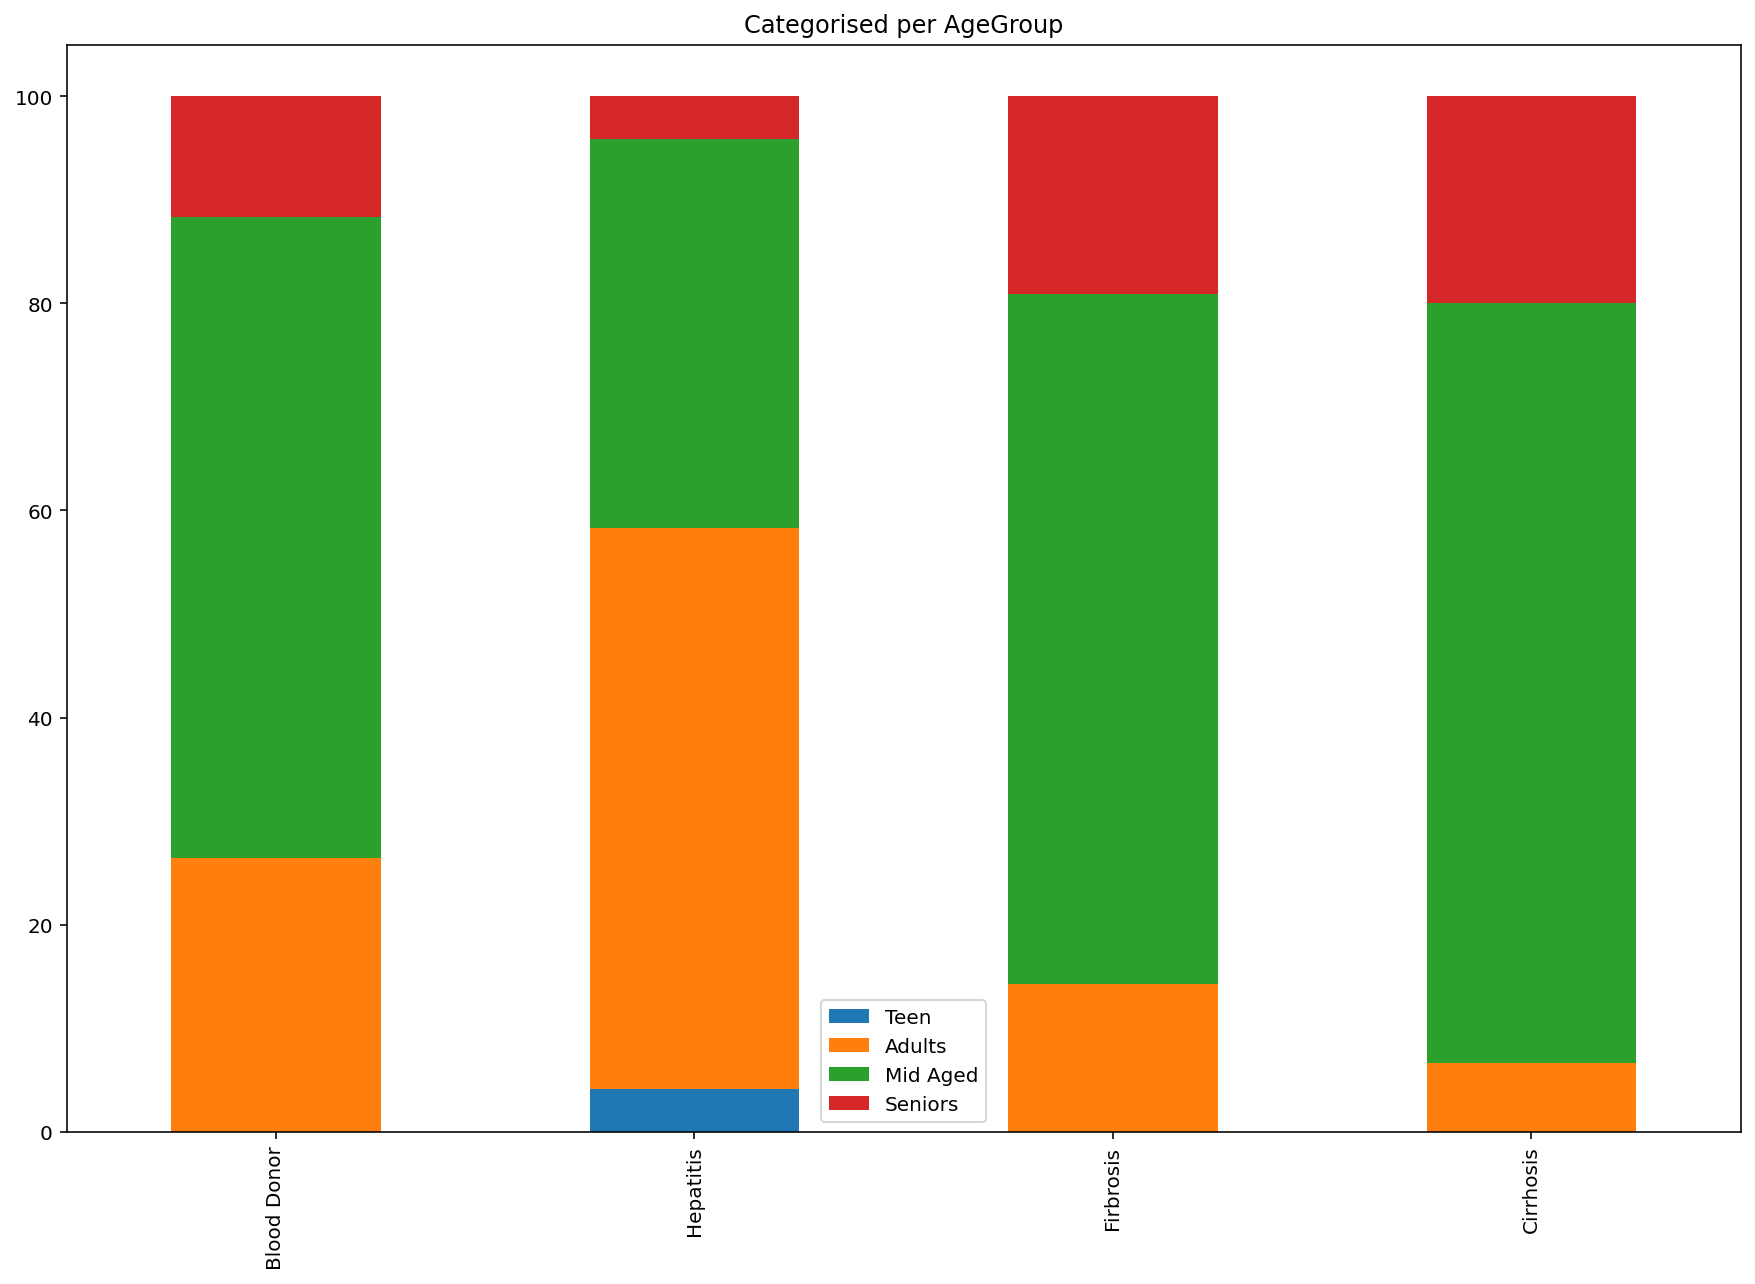

In [38]:
bar_chart_percent(hcdata_encoded, 'AgeGroup')

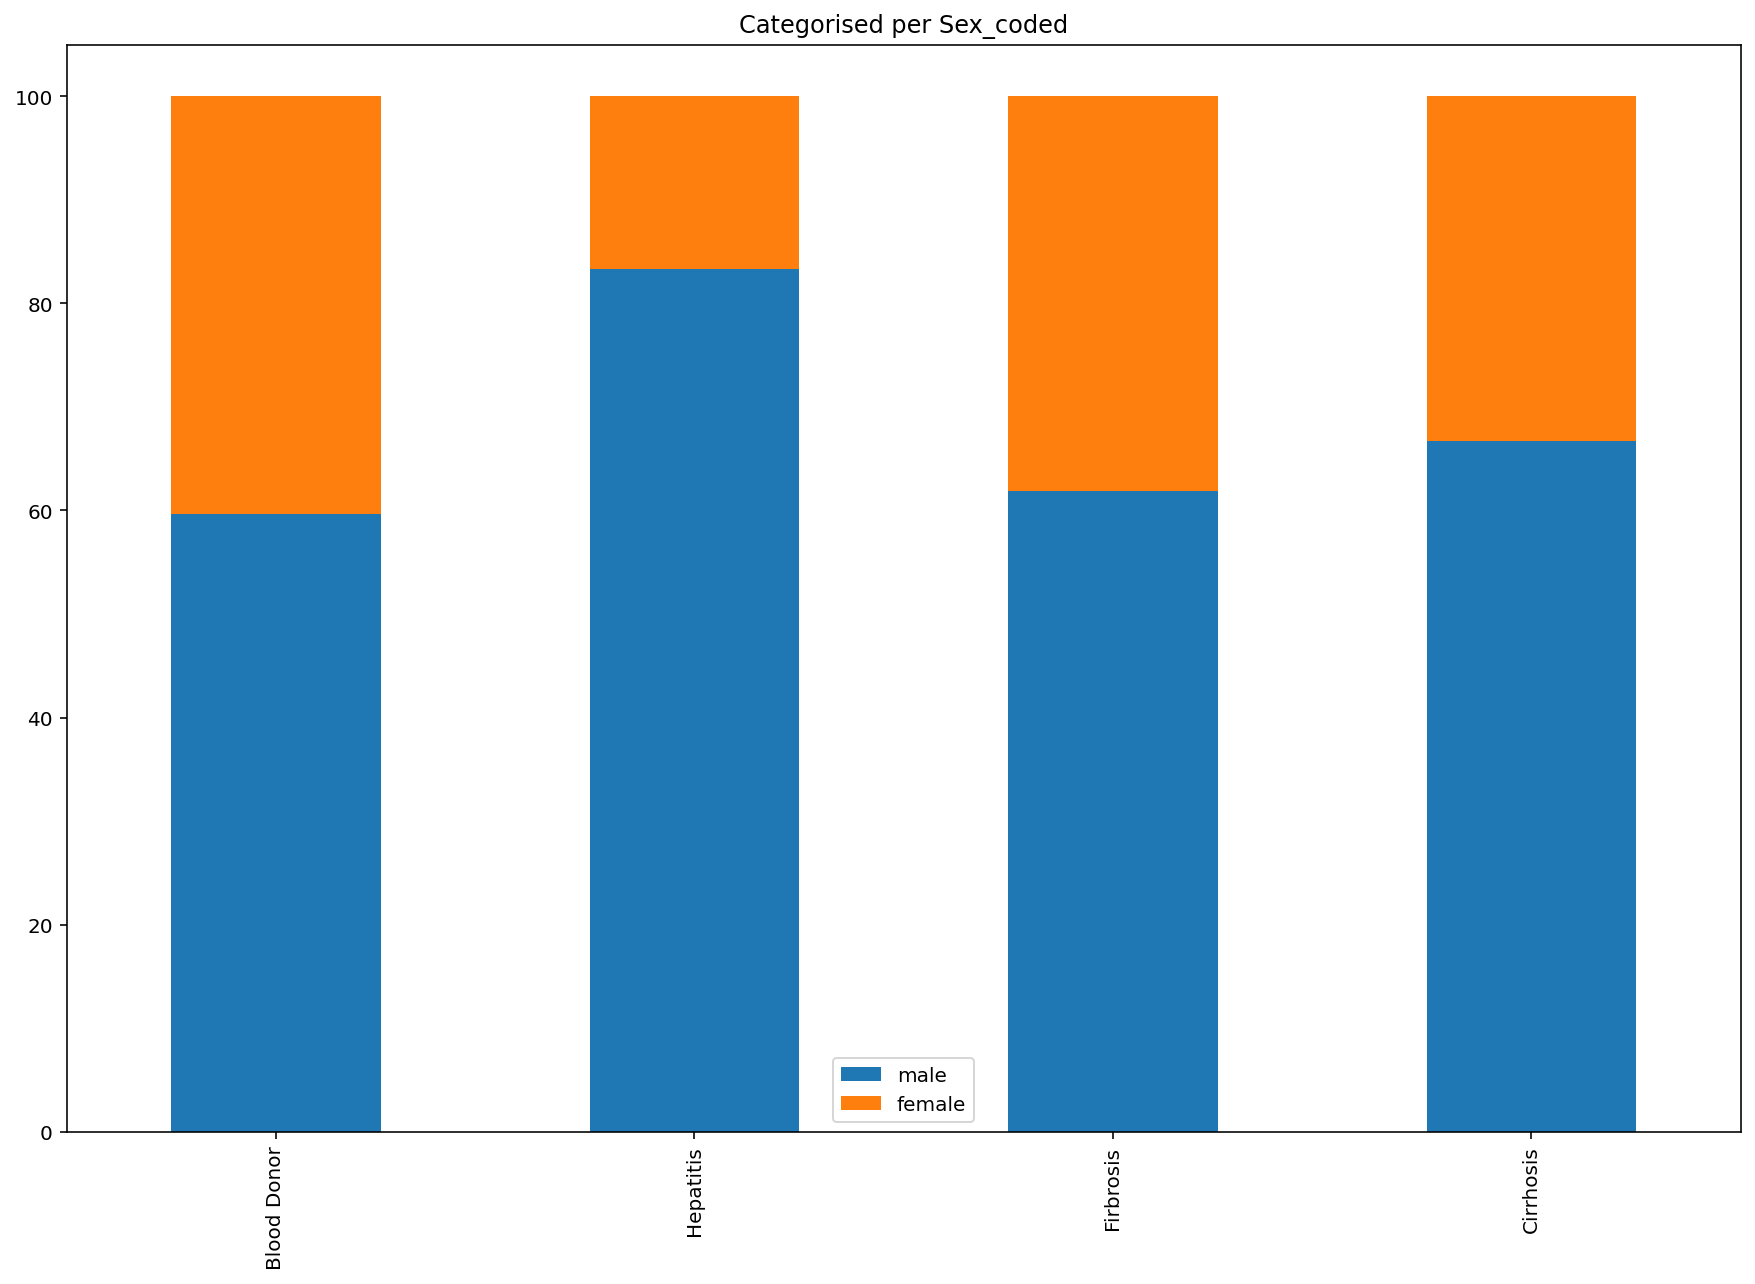

In [39]:
bar_chart_percent(hcdata_encoded, 'Sex_coded')

In [40]:
hcdata_encoded.drop(columns=['AgeGroup'], inplace=True)

In [41]:
hcdata_encoded.columns

Index(['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT',
       'PROT', 'Category_coded', 'Sex_coded'],
      dtype='object')

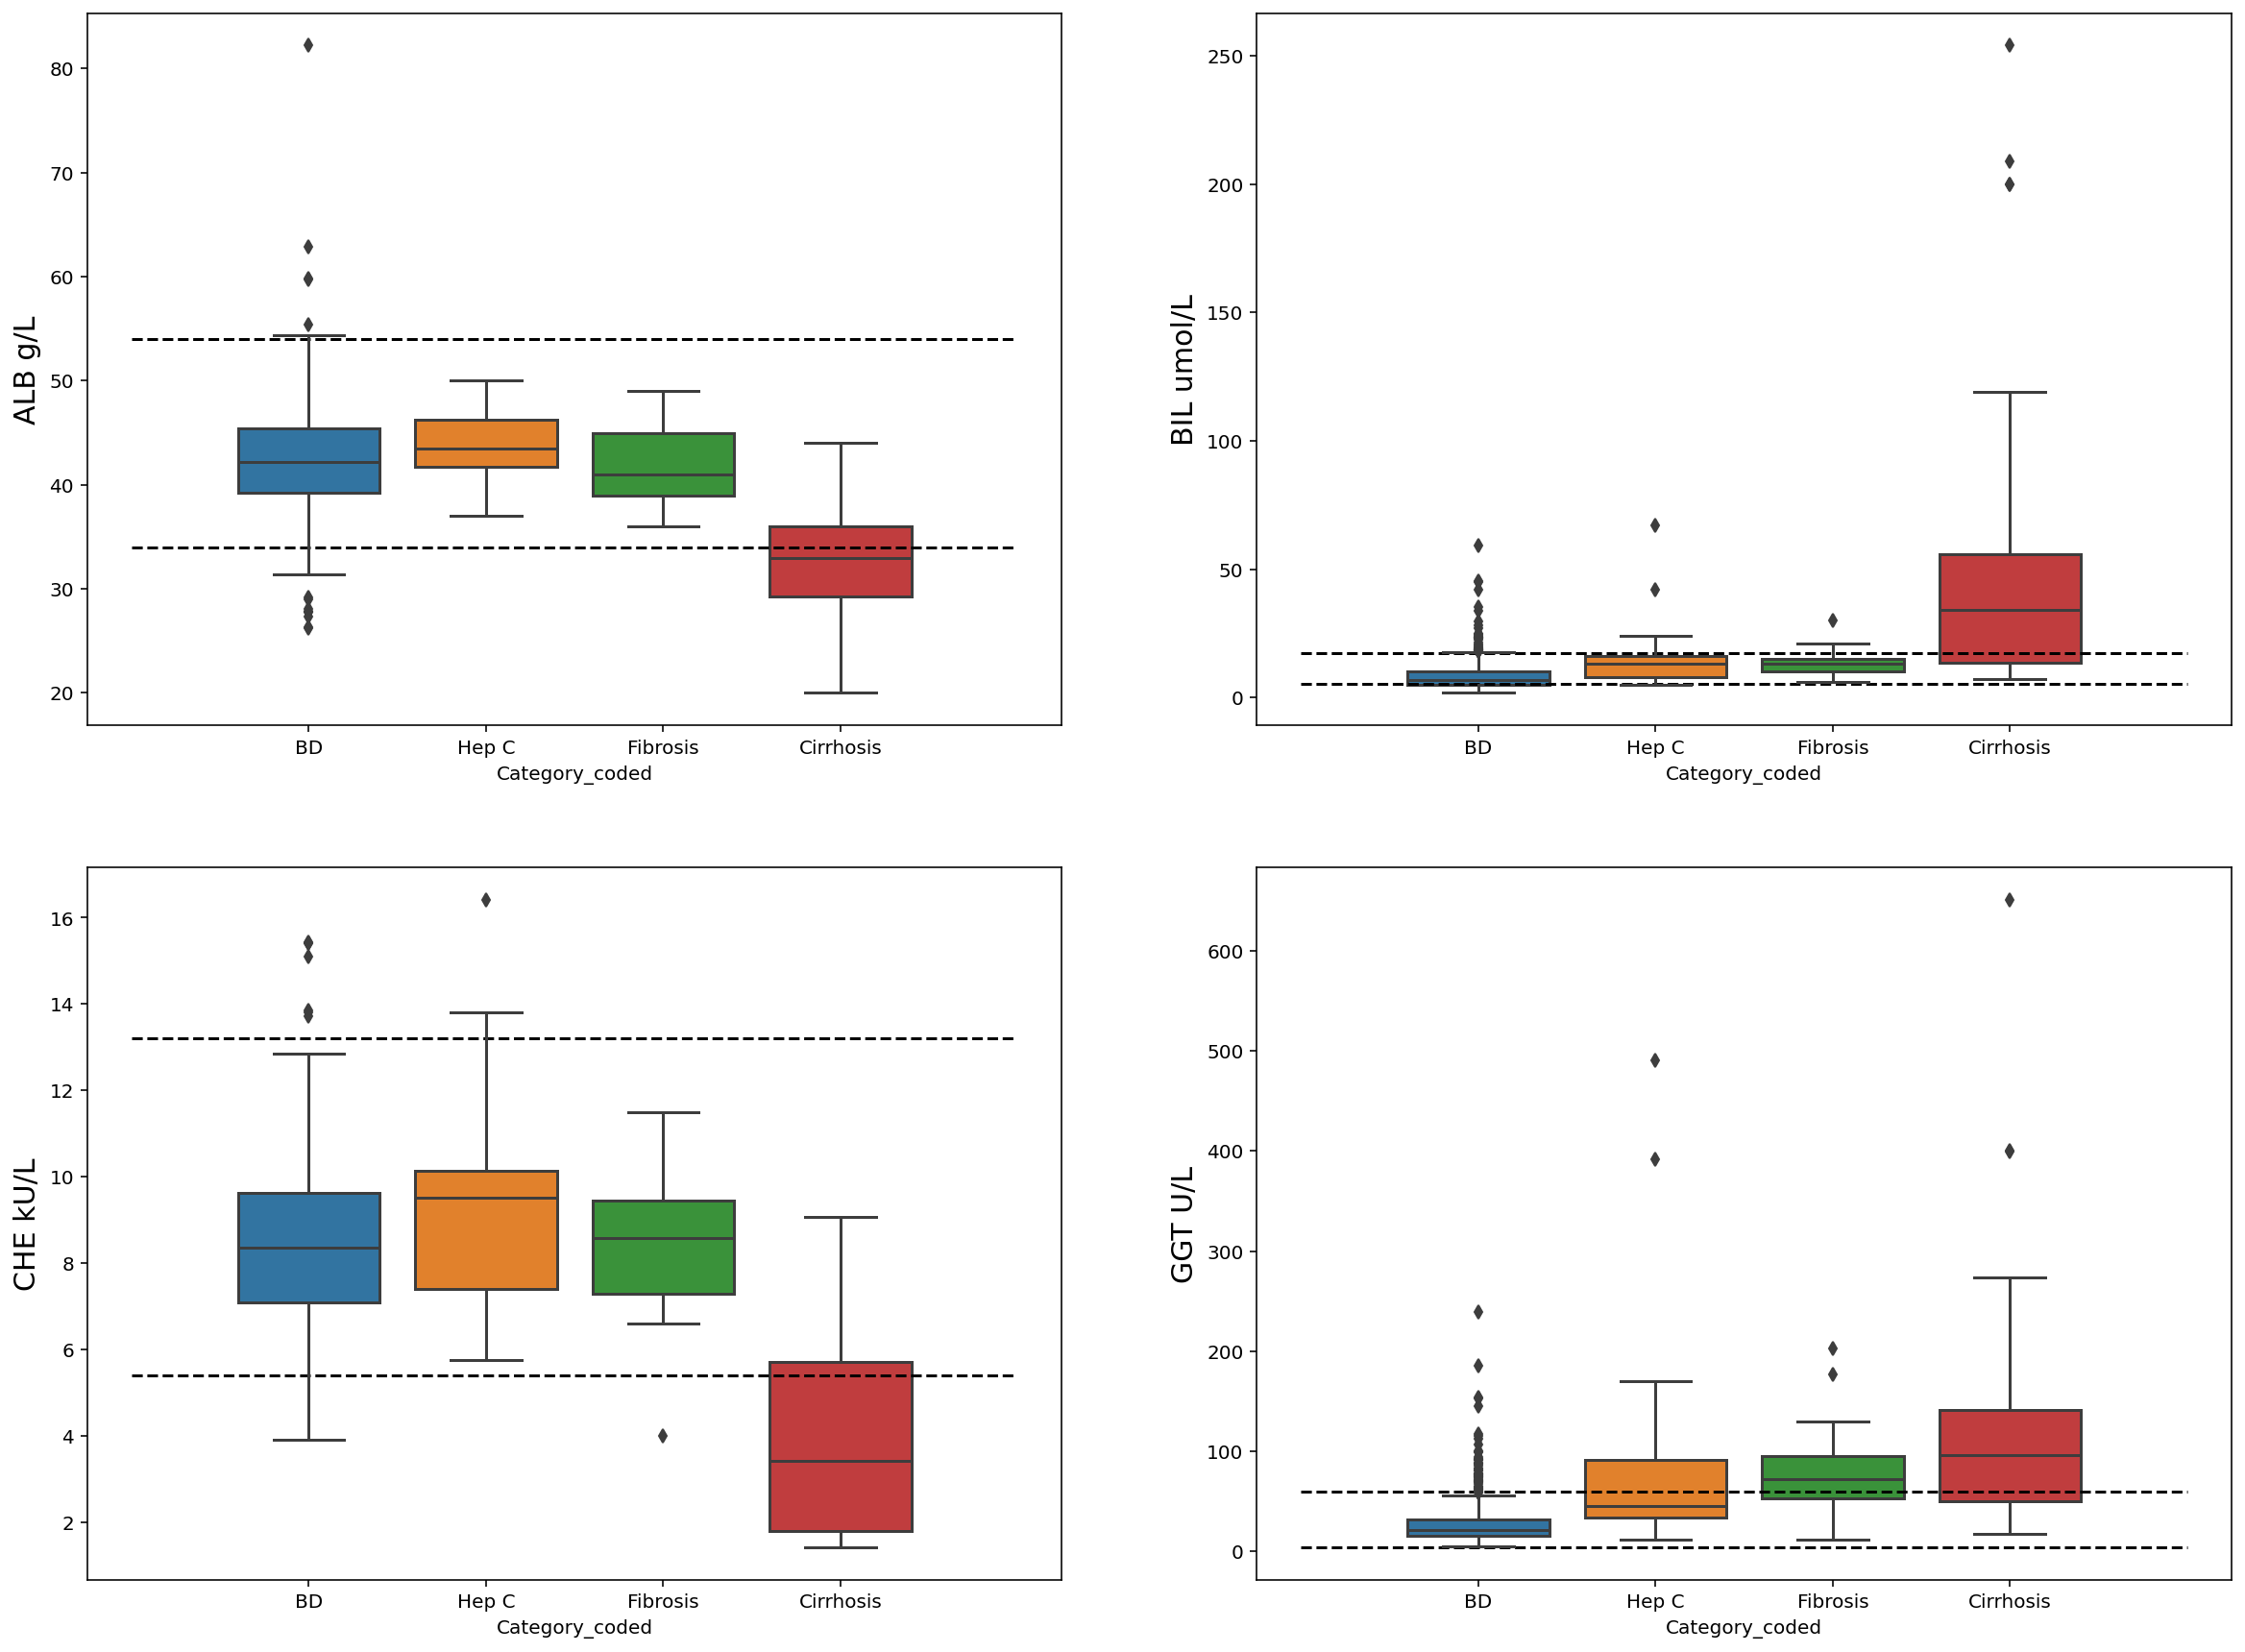

In [42]:
f, axes = plt.subplots(2,2, figsize=(20, 15), sharex=False)
ax1 = sns.boxplot(x = 'Category_coded', y = 'ALB', data = hcdata_encoded, ax=axes[0, 0])
ax1.hlines(34, -1, 4, linestyles='--')
ax1.hlines(54, -1, 4, linestyles='--')
ax1.set_ylabel("ALB g/L",fontsize=15)
plt.setp(ax1, xticks=[0,1,2,3], xticklabels=['BD', 'Hep C', 'Fibrosis', 'Cirrhosis'])
# ax1.set_xticks(ticks=['a', 'b', 'c', 'd', 'e'])

ax2 = sns.boxplot(x = 'Category_coded', y = 'BIL', data = hcdata_encoded, ax=axes[0, 1])
ax2.hlines(5.13, -1, 4, linestyles='--')
ax2.hlines(17.1, -1, 4, linestyles='--')
ax2.set_ylabel("BIL umol/L", fontsize=15)
plt.setp(ax2, xticks=[0,1,2,3], xticklabels=['BD', 'Hep C', 'Fibrosis', 'Cirrhosis'])

ax3 = sns.boxplot(x = 'Category_coded', y = 'CHE', data = hcdata_encoded, ax=axes[1, 0])
ax3.hlines(5.4, -1, 4, linestyles='--')
ax3.hlines(13.2, -1, 4, linestyles='--')
ax3.set_ylabel("CHE kU/L", fontsize=15)
plt.setp(ax3, xticks=[0,1,2,3], xticklabels=['BD', 'Hep C', 'Fibrosis', 'Cirrhosis'])

ax4 = sns.boxplot(x = 'Category_coded', y = 'GGT', data = hcdata_encoded, ax=axes[1, 1])
ax4.hlines(4, -1, 4, linestyles='--')
ax4.hlines(60, -1, 4, linestyles='--')
ax4.set_ylabel("GGT U/L", fontsize=15)
plt.setp(ax4, xticks=[0,1,2,3], xticklabels=['BD', 'Hep C', 'Fibrosis', 'Cirrhosis'])


plt.show()


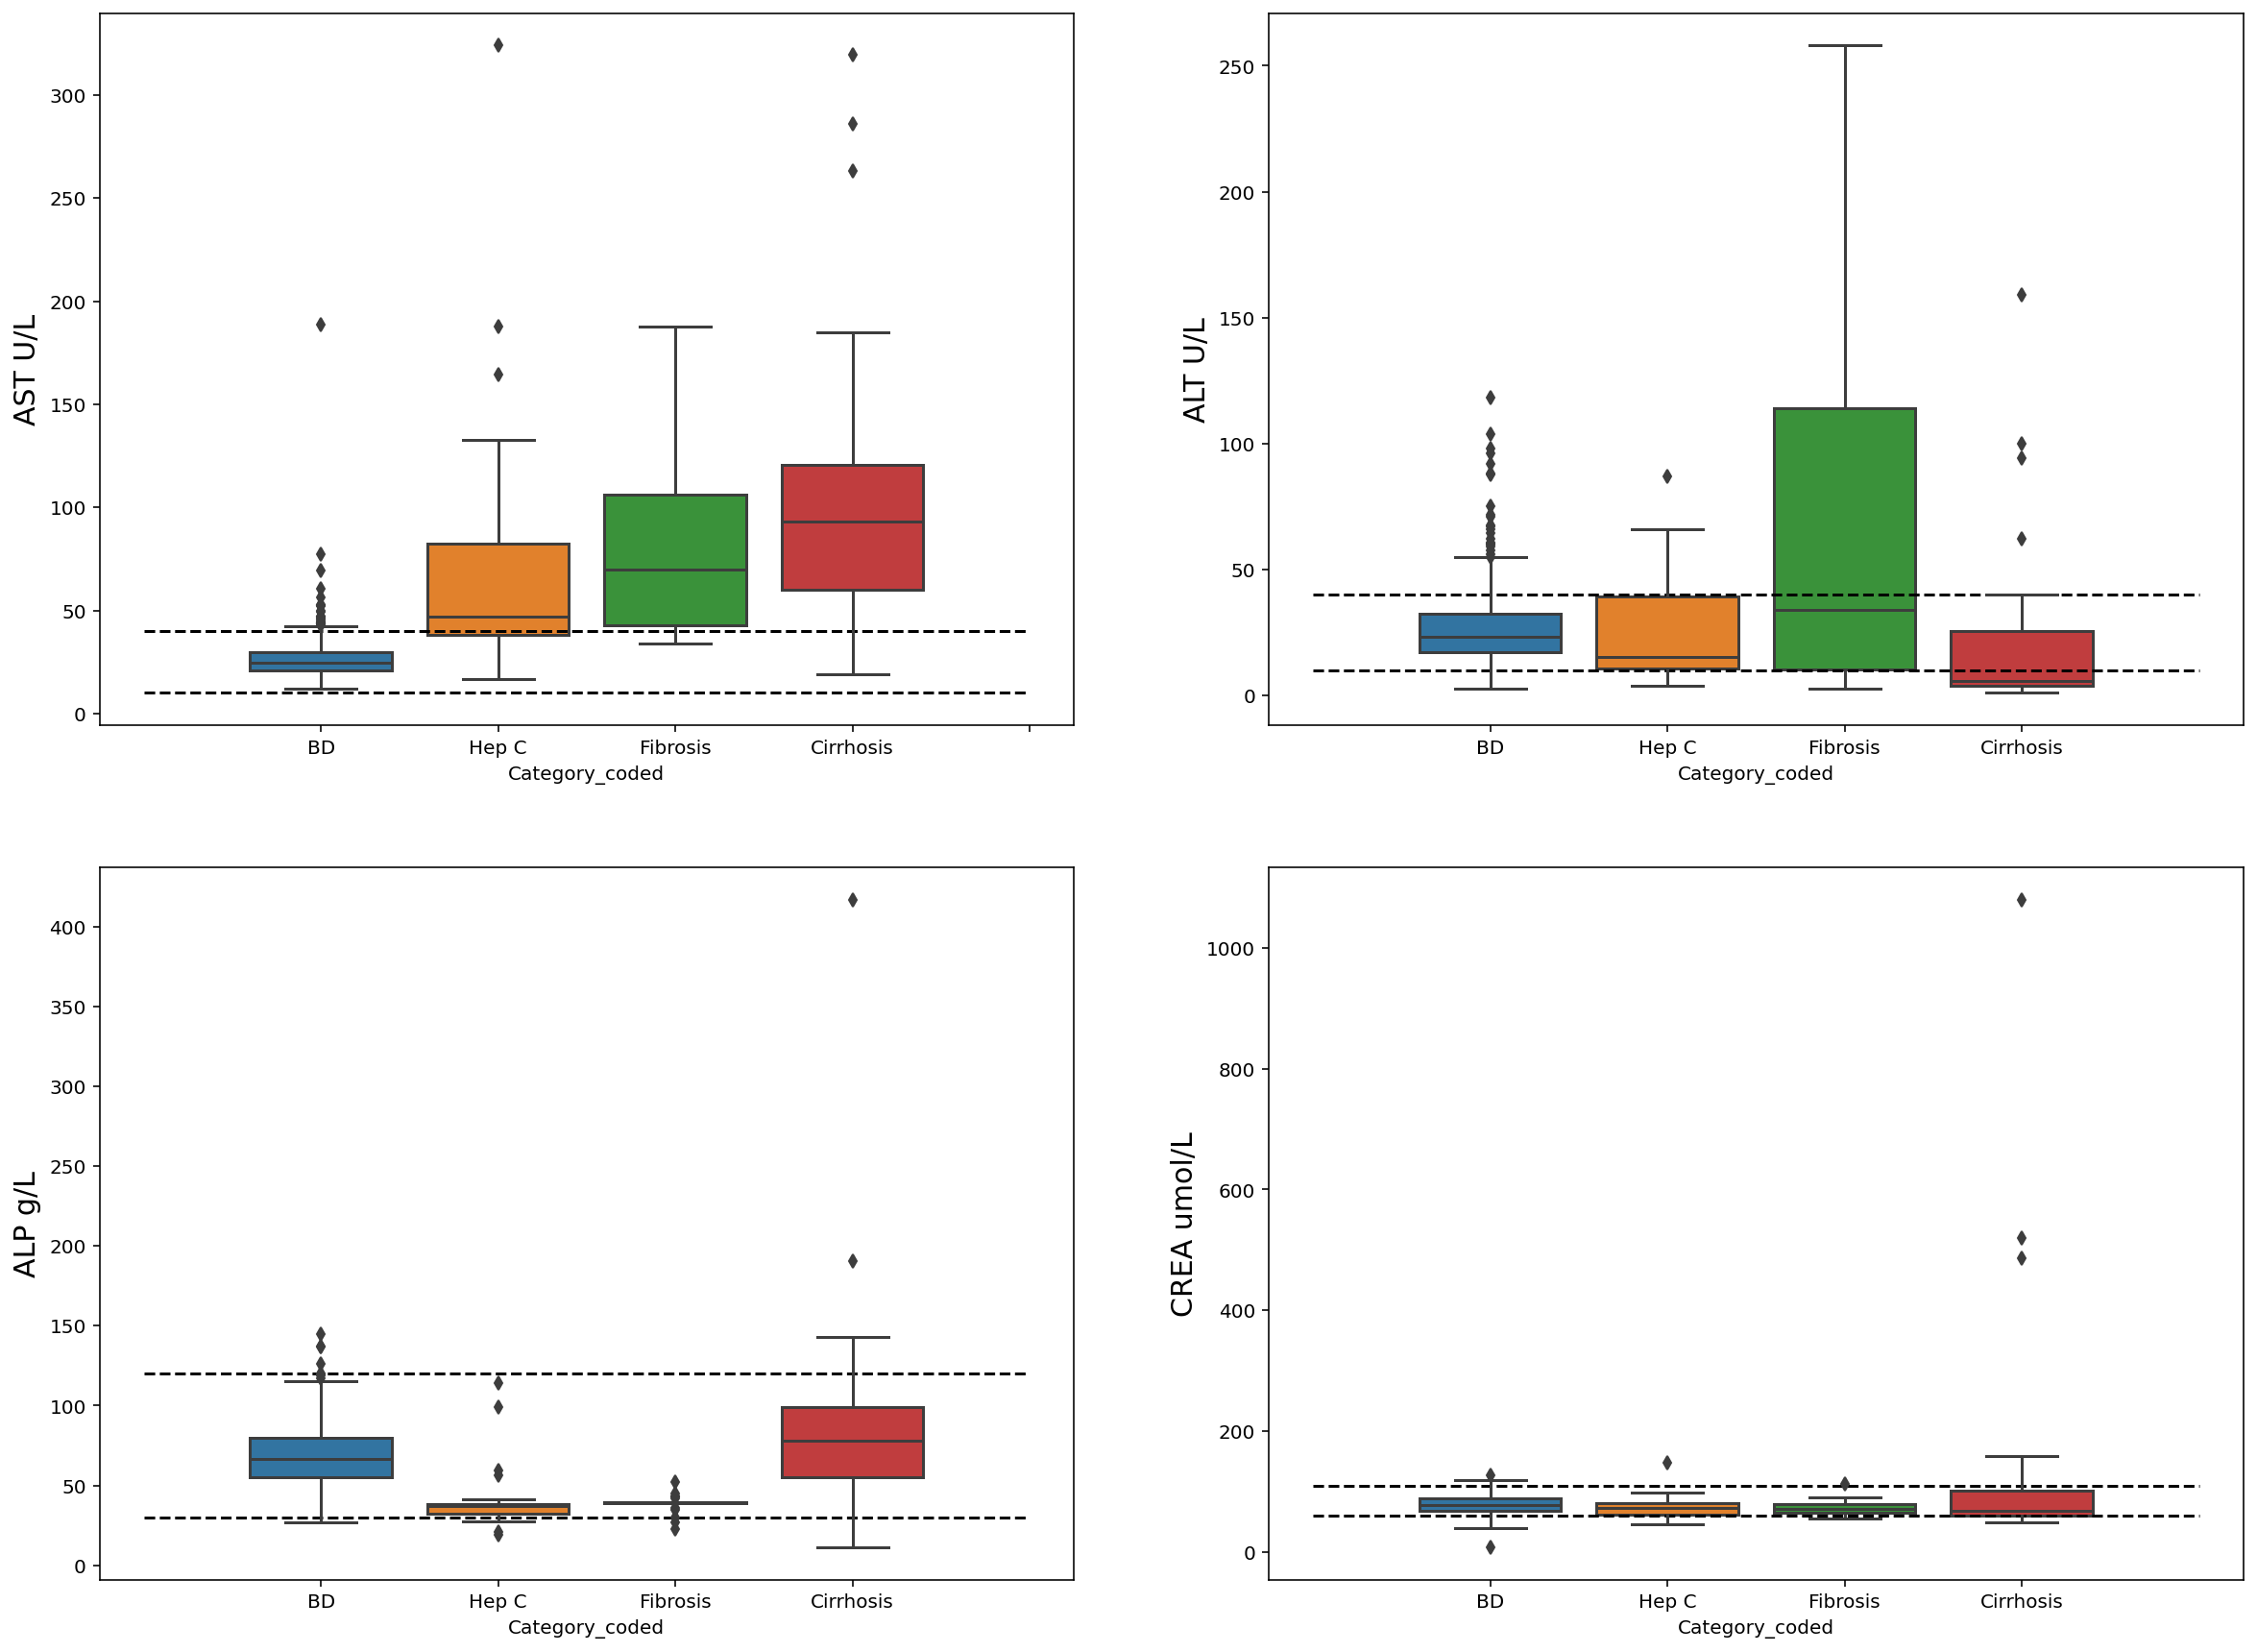

In [43]:
f, axes = plt.subplots(2,2, figsize=(20, 15), sharex=False)
ax5 = sns.boxplot(x = 'Category_coded', y = 'AST', data = hcdata_encoded, ax=axes[0, 0])
ax5.hlines(10, -1, 4, linestyles='--')
ax5.hlines(40, -1, 4, linestyles='--')
ax5.set_ylabel("AST U/L", fontsize=15)
plt.setp(ax5, xticks=[0,1,2,3,4], xticklabels=['BD', 'Hep C', 'Fibrosis', 'Cirrhosis'])

ax6 = sns.boxplot(x = 'Category_coded', y = 'ALT', data = hcdata_encoded, ax=axes[0, 1])
ax6.hlines(10, -1, 4, linestyles='--')
ax6.hlines(40, -1, 4, linestyles='--')
ax6.set_ylabel("ALT U/L", fontsize=15)
plt.setp(ax6, xticks=[0,1,2,3], xticklabels=['BD', 'Hep C', 'Fibrosis', 'Cirrhosis'])

ax8 = sns.boxplot(x = 'Category_coded', y = 'ALP', data = hcdata_encoded, ax=axes[1, 0])
ax8.hlines(30, -1, 4, linestyles='--')
ax8.hlines(120, -1, 4, linestyles='--')
ax8.set_ylabel("ALP g/L", fontsize=15)
plt.setp(ax8, xticks=[0,1,2,3], xticklabels=['BD', 'Hep C', 'Fibrosis', 'Cirrhosis'])

ax9 = sns.boxplot(x = 'Category_coded', y = 'CREA', data = hcdata_encoded, ax=axes[1, 1])
ax9.hlines(60, -1, 4, linestyles='--')
ax9.hlines(110, -1, 4, linestyles='--')
ax9.set_ylabel("CREA umol/L", fontsize=15)
plt.setp(ax9, xticks=[0,1,2,3], xticklabels=['BD', 'Hep C', 'Fibrosis', 'Cirrhosis'])

plt.show()


In [92]:
### Modelling

In [100]:
target_col = 'Category_coded'
feature_cols = [c for c in hcdata_encoded.columns if c != target_col]

X = hcdata_encoded[feature_cols]
y = hcdata_encoded[target_col]

In [101]:
## binarising the categories
y = label_binarize(hcdata_encoded['Category_coded'], classes=[0,1,2,3])

In [46]:
X

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_coded
0,32,38.5,52.50,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,1
1,32,38.5,70.30,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,1
2,32,46.9,74.70,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,1
3,32,43.2,52.00,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,1
4,32,39.2,74.10,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
610,62,32.0,416.60,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,0
611,64,24.0,102.80,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,0
612,64,29.0,87.30,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,0
613,46,33.0,83.15,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,0


In [47]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [48]:
n_classes = y.shape[1]
n_classes

4

In [103]:
oversample = SMOTE(k_neighbors=3)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=0)

In [122]:
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)

/Users/sangdonlee/opt/anaconda3/envs/python37-2/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [123]:
### Support Vector Machine

In [124]:
X_resampled.shape

(1272, 12)

In [125]:
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True,
                                 random_state=42))

In [126]:
y_score = classifier.fit(X_resampled, y_resampled).decision_function(X_test)

In [127]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

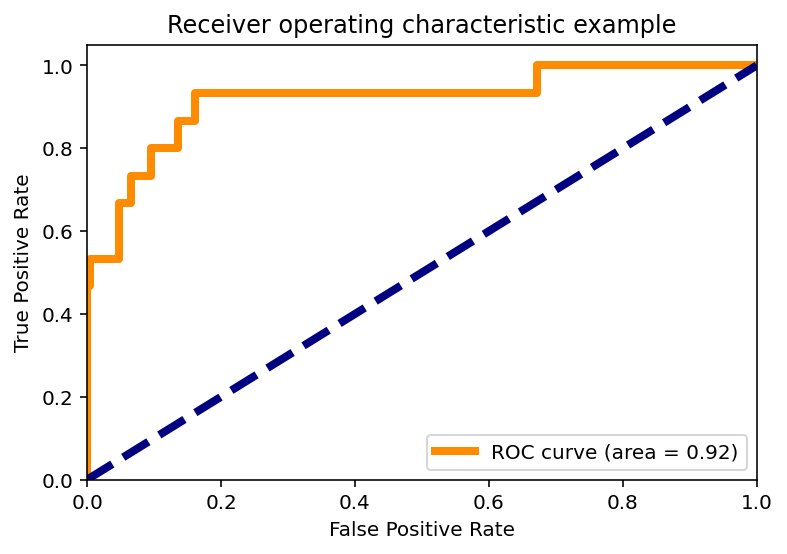

In [128]:
plt.figure()
lw = 4
plt.plot(fpr[3], tpr[3], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [129]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [130]:
mean_tpr = np.zeros_like(all_fpr)

In [131]:
mean_tpr
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr

/Users/sangdonlee/opt/anaconda3/envs/python37-2/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  This is separate from the ipykernel package so we can avoid doing imports until


array([0.46666667, 0.75238095, 0.81904762, 0.96190476, 1.24761905,
       1.81904762, 1.98183832, 2.11517165, 2.18183832, 2.5585825 ,
       2.70143965, 2.76810631, 2.85647841, 2.92314507, 3.21151717,
       3.27818383, 3.28283499, 3.29678848, 3.30609081, 3.31539313,
       3.32469546, 3.4675526 , 3.48615725, 3.6290144 , 3.63366556,
       3.63831672, 3.64296788, 3.78582503, 3.92868217, 3.99534884,
       4.        , 4.        ])

In [132]:
mean_tpr /= n_classes
mean_tpr

array([0.11666667, 0.18809524, 0.2047619 , 0.24047619, 0.31190476,
       0.4547619 , 0.49545958, 0.52879291, 0.54545958, 0.63964563,
       0.67535991, 0.69202658, 0.7141196 , 0.73078627, 0.80287929,
       0.81954596, 0.82070875, 0.82419712, 0.8265227 , 0.82884828,
       0.83117386, 0.86688815, 0.87153931, 0.9072536 , 0.90841639,
       0.90957918, 0.91074197, 0.94645626, 0.98217054, 0.99883721,
       1.        , 1.        ])

In [133]:
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

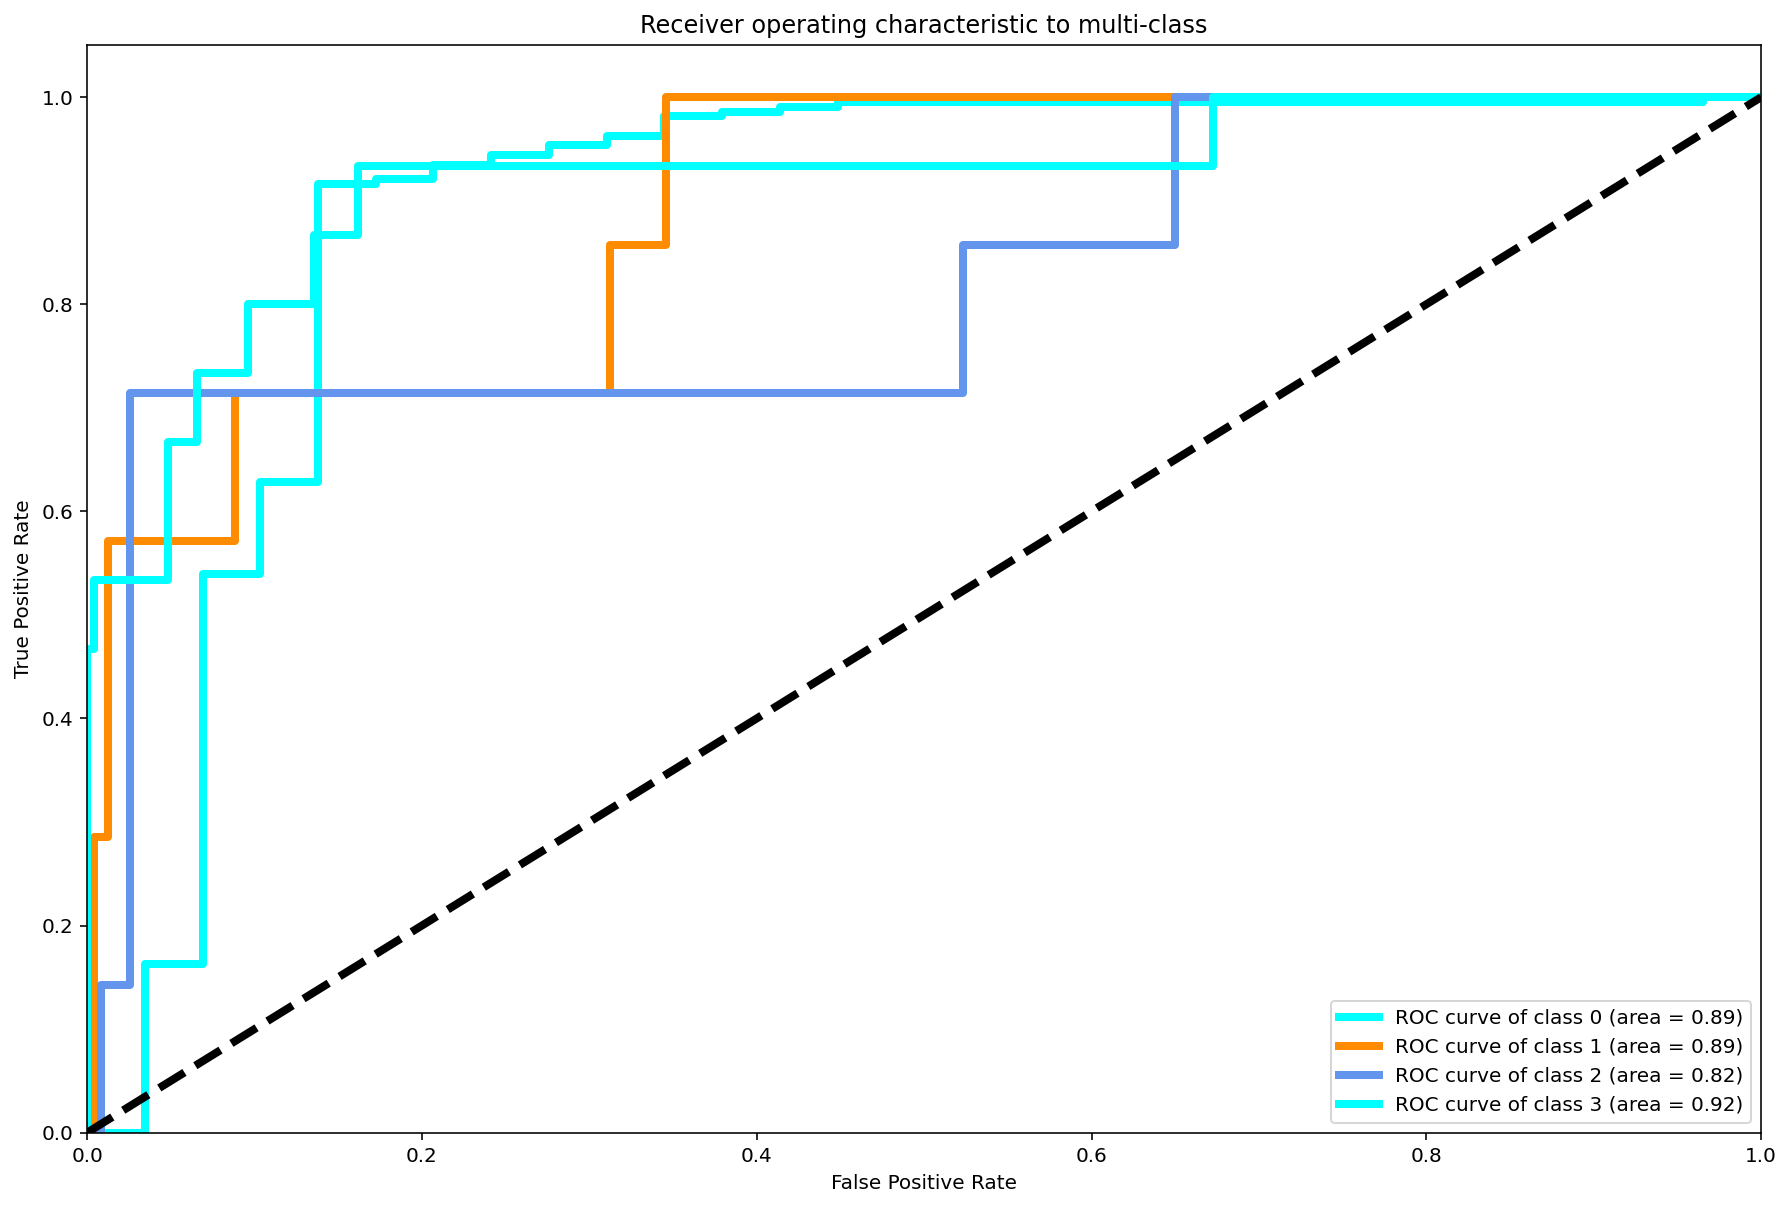

In [134]:
# Plot all ROC curves
plt.figure(figsize=(15,10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [135]:
y_pred = classifier.predict(X_test)

Micro Precision: 0.90
Micro Recall: 0.89
Micro F1-score: 0.90

Macro Precision: 0.63
Macro Recall: 0.69
Macro F1-score: 0.64

Weighted Precision: 0.93
Weighted Recall: 0.89
Weighted F1-score: 0.90
              precision    recall  f1-score   support

     Class 0       0.97      0.93      0.95       215
     Class 1       0.31      0.57      0.40         7
     Class 2       0.45      0.71      0.56         7
     Class 3       0.80      0.53      0.64        15

   micro avg       0.90      0.89      0.90       244
   macro avg       0.63      0.69      0.64       244
weighted avg       0.93      0.89      0.90       244
 samples avg       0.86      0.89      0.87       244



/Users/sangdonlee/opt/anaconda3/envs/python37-2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Prediction')

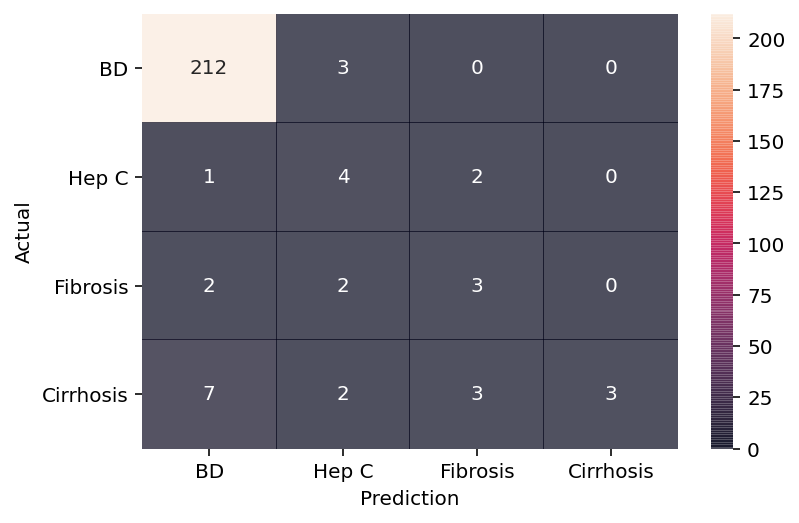

In [136]:
print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt="d", alpha = 0.7, xticklabels=['BD', 'Hep C', 'Fibrosis','Cirrhosis'], yticklabels=['BD', 'Hep C', 'Fibrosis','Cirrhosis'])
plt.yticks(rotation=0)
plt.ylabel('Actual')
plt.xlabel('Prediction')


In [140]:
classifier_log = OneVsRestClassifier(LogisticRegression(max_iter=10000, random_state=42))

In [141]:
y_score_log = classifier_log.fit(X_resampled, y_resampled).decision_function(X_test)

In [142]:
fpr_log = dict()
tpr_log = dict()
roc_auc_log = dict()
for i in range(n_classes):
    fpr_log[i], tpr_log[i], _ = roc_curve(y_test[:, i], y_score_log[:, i])
    roc_auc_log[i] = auc(fpr_log[i], tpr_log[i])

# Compute micro-average ROC curve and ROC area
fpr_log["micro"], tpr_log["micro"], _ = roc_curve(y_test.ravel(), y_score_log.ravel())
roc_auc_log["micro"] = auc(fpr_log["micro"], tpr_log["micro"])

In [143]:
roc_auc_log

{0: 0.9037690457097033,
 1: 0.9035563592525617,
 2: 0.7751657625075347,
 3: 0.9289665211062591,
 'micro': 0.9688703753471289}

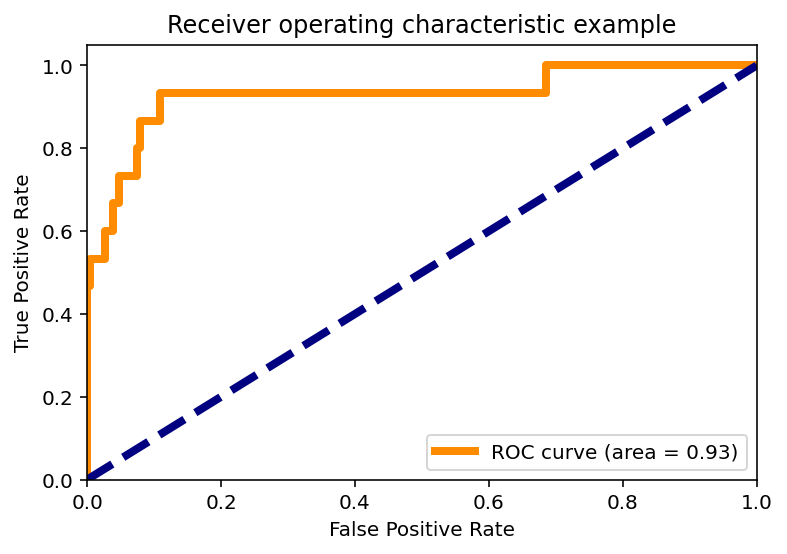

In [144]:
plt.figure()
lw = 4
plt.plot(fpr_log[3], tpr_log[3], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_log[3])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [145]:
all_fpr_log = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [146]:
mean_tpr_log = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr_log += interp(all_fpr, fpr_log[i], tpr_log[i])

/Users/sangdonlee/opt/anaconda3/envs/python37-2/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [147]:
fpr_log["macro"] = all_fpr_log
tpr_log["macro"] = mean_tpr_log
roc_auc_log["macro"] = auc(fpr_log["macro"], tpr_log["macro"])

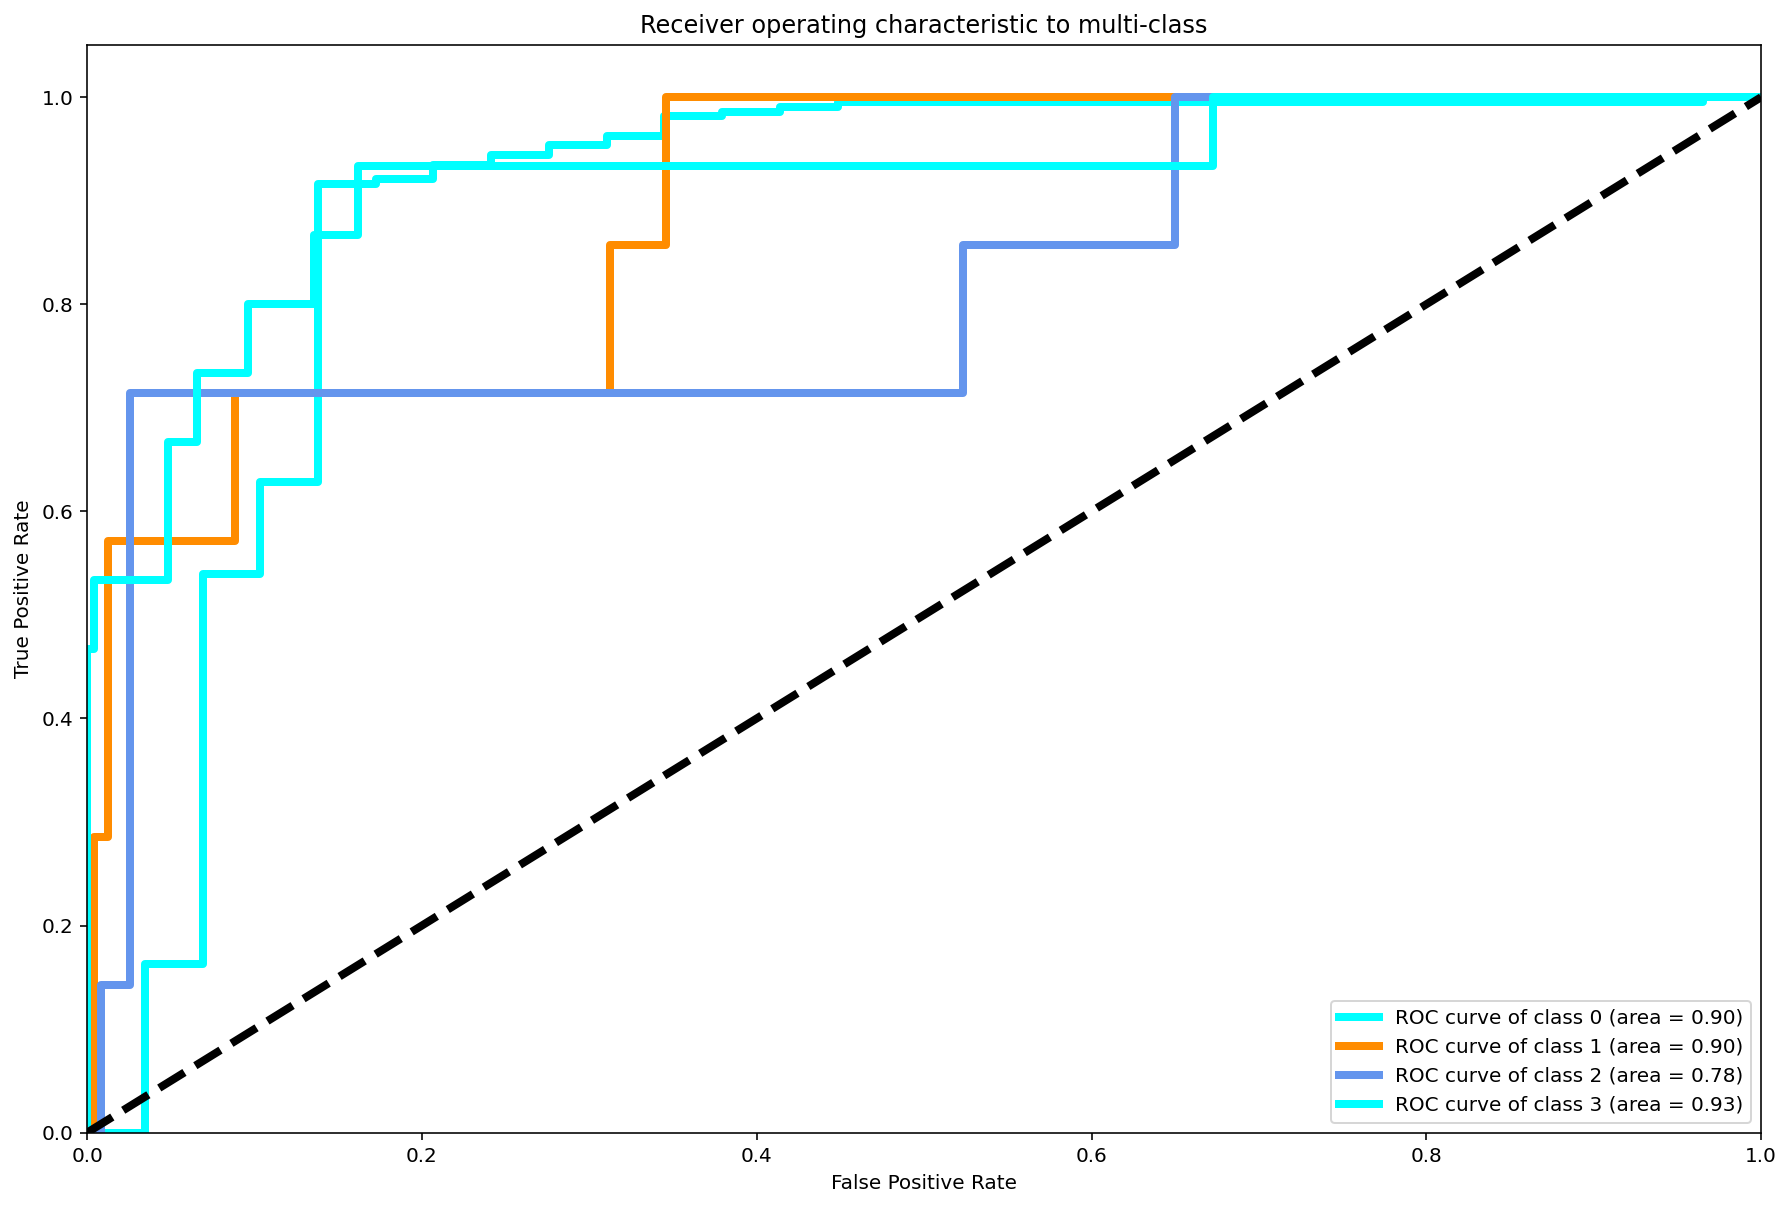

In [148]:
# Plot all ROC curves
plt.figure(figsize=(15,10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_log[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [149]:
y_pred_log = classifier_log.predict(X_test)

Micro Precision: 0.89
Micro Recall: 0.89
Micro F1-score: 0.89

Macro Precision: 0.57
Macro Recall: 0.62
Macro F1-score: 0.58

Weighted Precision: 0.92
Weighted Recall: 0.89
Weighted F1-score: 0.90
              precision    recall  f1-score   support

     Class 0       0.97      0.93      0.95       215
     Class 1       0.31      0.57      0.40         7
     Class 2       0.27      0.43      0.33         7
     Class 3       0.73      0.53      0.62        15

   micro avg       0.89      0.89      0.89       244
   macro avg       0.57      0.62      0.58       244
weighted avg       0.92      0.89      0.90       244
 samples avg       0.85      0.89      0.86       244



/Users/sangdonlee/opt/anaconda3/envs/python37-2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Prediction')

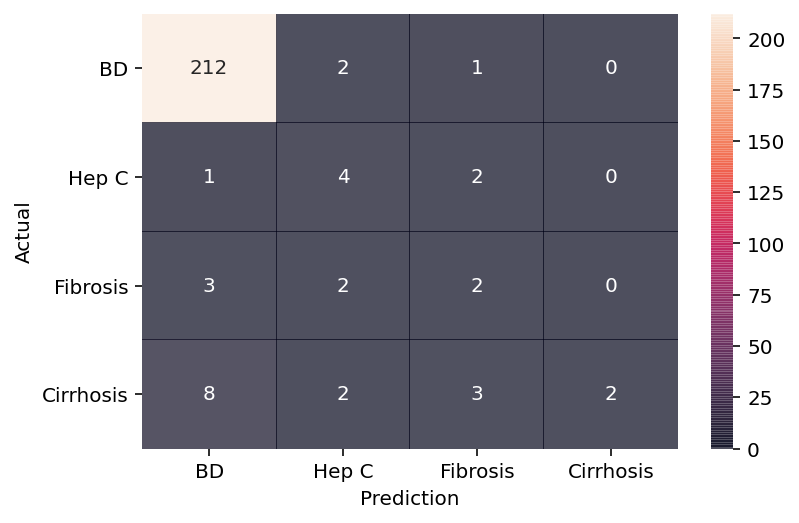

In [150]:
print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred_log, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred_log, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred_log, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred_log, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred_log, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred_log, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred_log, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred_log, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred_log, average='weighted')))
print(classification_report(y_test, y_pred_log, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_log.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt="d", alpha = 0.7, xticklabels=['BD', 'Hep C', 'Fibrosis','Cirrhosis'], yticklabels=['BD', 'Hep C', 'Fibrosis','Cirrhosis'])
plt.yticks(rotation=0)
plt.ylabel('Actual')
plt.xlabel('Prediction')

In [156]:
y_pred_log = classifier_log.predict(X_resampled)

Micro Precision: 0.93
Micro Recall: 0.92
Micro F1-score: 0.92

Macro Precision: 0.93
Macro Recall: 0.92
Macro F1-score: 0.92

Weighted Precision: 0.93
Weighted Recall: 0.92
Weighted F1-score: 0.92
              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.97       318
     Class 1       0.86      0.86      0.86       318
     Class 2       0.90      0.85      0.88       318
     Class 3       0.96      0.98      0.97       318

   micro avg       0.93      0.92      0.92      1272
   macro avg       0.93      0.92      0.92      1272
weighted avg       0.93      0.92      0.92      1272
 samples avg       0.90      0.92      0.90      1272



/Users/sangdonlee/opt/anaconda3/envs/python37-2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Prediction')

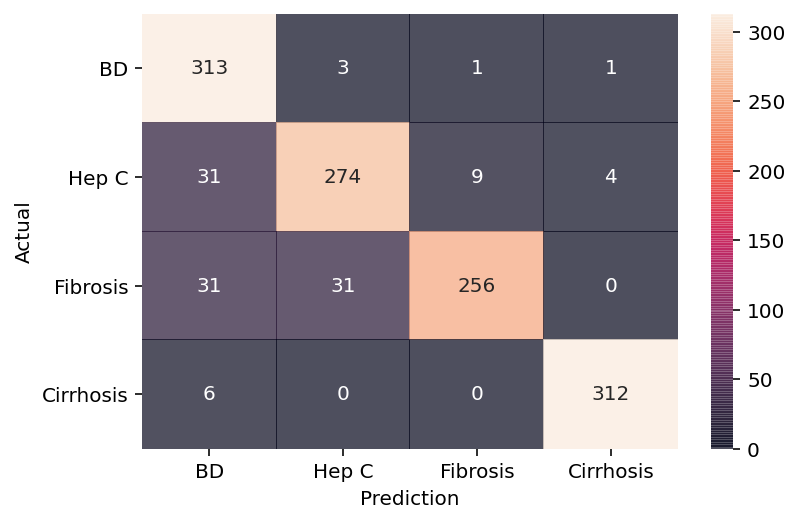

In [159]:
print('Micro Precision: {:.2f}'.format(precision_score(y_resampled, y_pred_log, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_resampled, y_pred_log, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_resampled, y_pred_log, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_resampled, y_pred_log, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_resampled, y_pred_log, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_resampled, y_pred_log, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_resampled, y_pred_log, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_resampled, y_pred_log, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_resampled, y_pred_log, average='weighted')))
print(classification_report(y_resampled, y_pred_log, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))
cm = confusion_matrix(y_resampled.argmax(axis=1), y_pred_log.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt="d", alpha = 0.7, xticklabels=['BD', 'Hep C', 'Fibrosis','Cirrhosis'], yticklabels=['BD', 'Hep C', 'Fibrosis','Cirrhosis'])
plt.yticks(rotation=0)
plt.ylabel('Actual')
plt.xlabel('Prediction')